> 1. Turn your visualizations from Assignment 1 into a report (e.g. Doc file) explaining what you have found so far and what your next steps might be to answer the mini challenge.
> 2. Visualize a sound file as a signal
> 3. Collect a list of methods to classify bird sound from the literature, starting from e.g. Automated bird sound recognition in realistic settings and its references.
> 4. Visualize multiple audio signals and their 2D spectrograms to facilitate visual inspection and comparison
Although automated classification can be applied to Kasios sound files, find some visual features that can be highlighted in the visualization to help understand the most important features for discriminating bird sounds? You don't need to be 100% successful of course.

##  Package

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from pydub import AudioSegment
import scipy as sp
from scipy.io import wavfile
from scipy import signal
from scipy.fftpack import fft,irfft,rfft,ifft,fftfreq,fftshift
import seaborn as sns
import os
import math
import pickle
import csv
from heapq import nlargest
import shutil
import re
import cv2

import pandas as pd
import sklearn as sk
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


sns.set()

# 1 Pre-processing and  feature extraction

## 1.1 Raw data, spectrum and spectrogram

In [829]:
#transform all mp3 files to wav
for file in os.listdir('data_2/ALL BIRDS/'):
    sound = AudioSegment.from_mp3("data_2/ALL BIRDS/" + file)
    sound.export("data_2/birds_wav/" + file.split('.')[0] + ".wav", format="wav")

In [459]:
def plot_wav(rate, data):    
    Time=np.linspace(0, float(len(data))/rate, num=len(data))

    n_sample = len(data)
    sample_space = 1.0/rate

    xf = np.linspace(0.0, 1.0/(2.0*sample_space),n_sample//2)
    
    fig, [ax1,ax2,ax3] = plt.subplots(nrows=3, ncols=1,figsize=(18,18))
    ax1.set_title('Raw Wave')
    ax1.plot(Time,data,"b")
    ax1.set_xlabel("Time(s)")
    ax1.set_ylabel("Amplitude")

    ax2.plot(xf, 2.0/n_sample * np.abs(np.fft.fft(data)[0:n_sample//2]),"b")
    ax2.set_title('Spectrum')
    ax2.set_ylabel('FFT magnitude')
    ax2.set_xlabel('Frequency')

    ax3.set_title('Spectrogram')
    ax3.specgram(data, Fs=rate,cmap='Blues') #overlap choice
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Frequency')
    ax3.grid(False)

    plt.show()

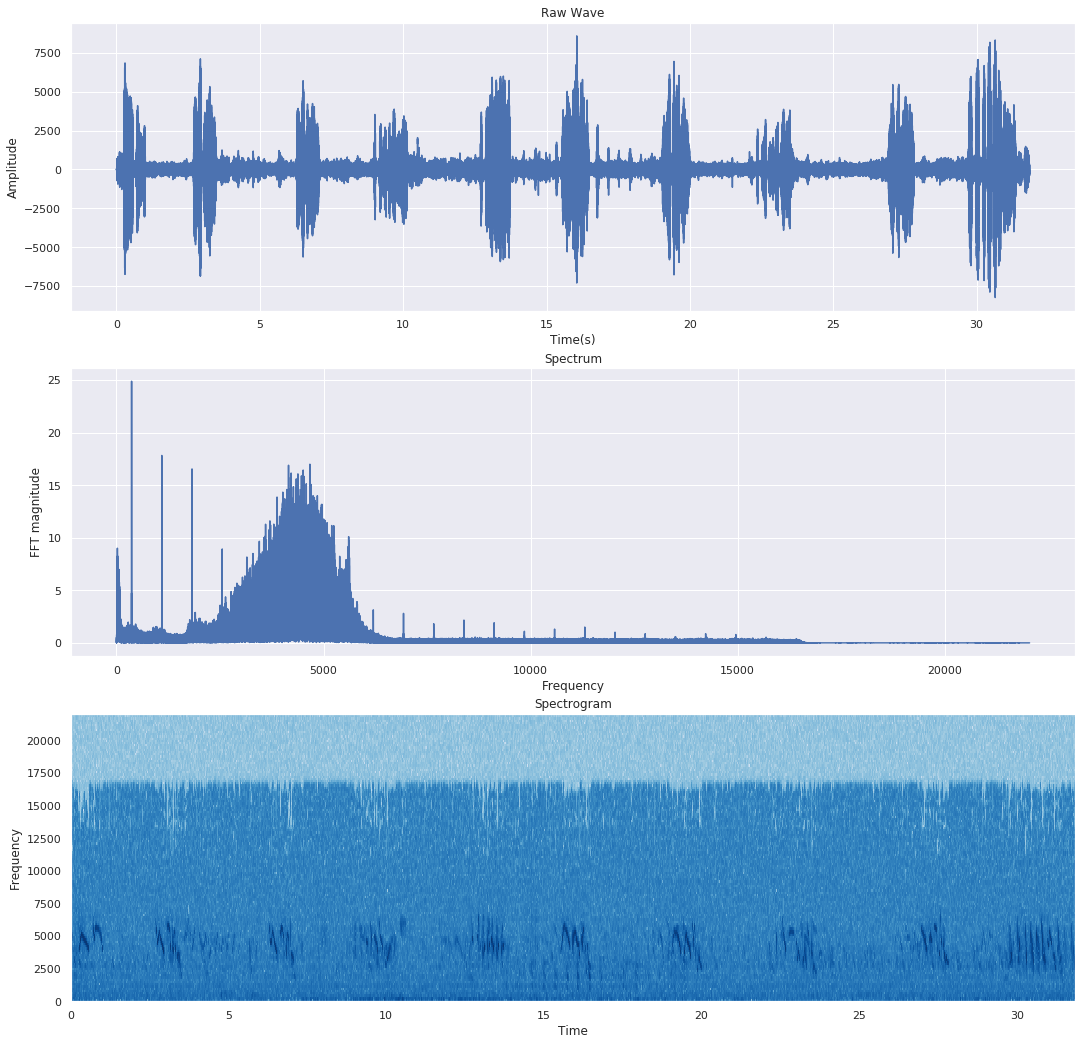

In [452]:
#example:
rate,test=wavfile.read("data_2/birds_wav/Rose-Crested-Blue-Pipit-191415.wav",'r')
if test.ndim==2:
    test=test[:,0]

plot_wav(rate,test)

In [830]:
#take all the birds_name
birds_name = set()

for file in os.listdir('data_2/ALL_BIRDS/'):
    birds_name.add('-'.join(file.split('-')[:-1]))
birds_name=list(birds_name) 
print(birds_name)

['Pinkfinch', 'Queenscoat', 'Lesser-Birchbeere', 'Broad-winged-Jojo', 'Bent-Beak-Riffraff', 'Orange-Pine-Plover', 'Darkwing-Sparrow', 'Qax', 'Eastern-Corn-Skeet', 'Bombadil', 'Purple-Tooting-Tout', 'Ordinary-Snape', 'Canadian-Cootamum', 'Rose-Crested-Blue-Pipit', 'Scrawny-Jay', 'Vermillion-Trillian', 'Blue-collared-Zipper', 'Green-Tipped-Scarlet-Pipit', 'Carries-Champagne-Pipit']


In [831]:
sample_birds = []

for name in birds_name:
    for name2 in os.listdir('data_2/birds_wav/'):
        if '-'.join(name2.split('-')[:-1]) == name:
            sample_birds.append(name2)
            break

In [832]:
sample_birds

['Pinkfinch-297560.wav',
 'Queenscoat-315730.wav',
 'Lesser-Birchbeere-76499.wav',
 'Broad-winged-Jojo-164751.wav',
 'Bent-Beak-Riffraff-69888.wav',
 'Orange-Pine-Plover-83517.wav',
 'Darkwing-Sparrow-240216.wav',
 'Qax-313535.wav',
 'Eastern-Corn-Skeet-1375.wav',
 'Bombadil-296886.wav',
 'Purple-Tooting-Tout-362567.wav',
 'Ordinary-Snape-193146.wav',
 'Canadian-Cootamum-181303.wav',
 'Rose-Crested-Blue-Pipit-14877.wav',
 'Scrawny-Jay-2631.wav',
 'Vermillion-Trillian-327481.wav',
 'Blue-collared-Zipper-131815.wav',
 'Green-Tipped-Scarlet-Pipit-46755.wav',
 'Carries-Champagne-Pipit-91299.wav']

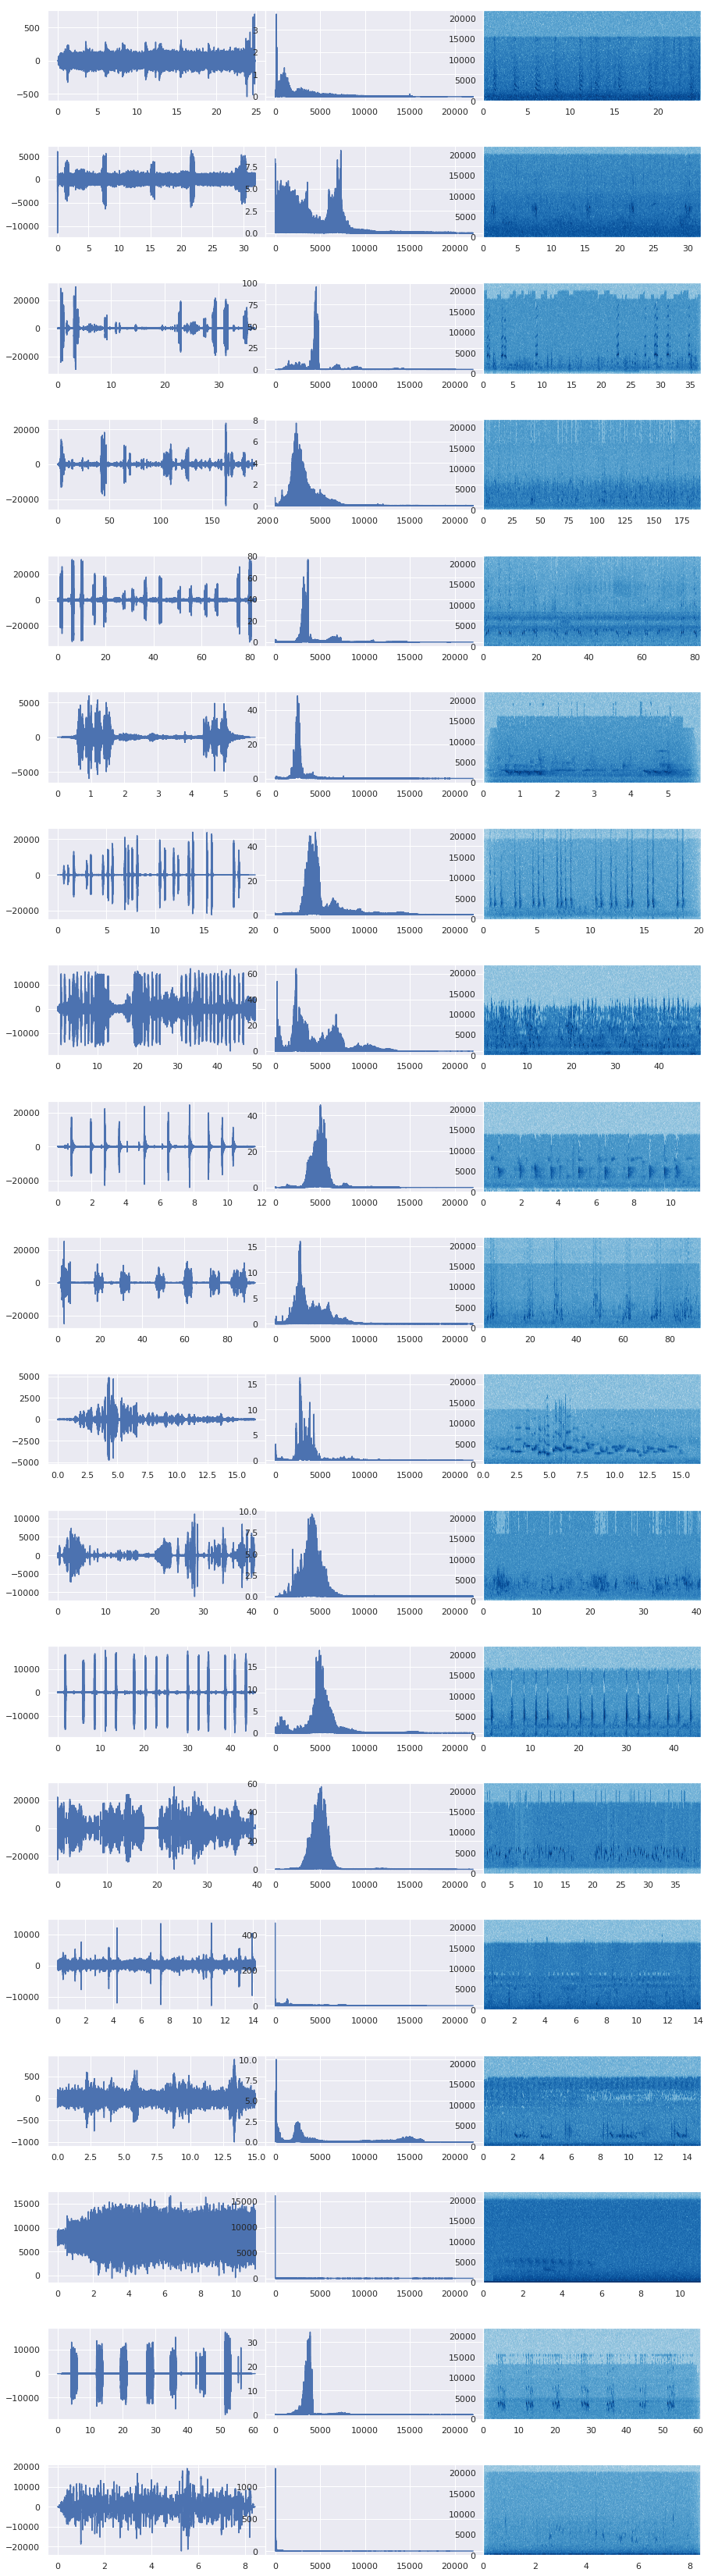

In [834]:
#plot multiple audio signals and their 2D spectrograms
fig, axs = plt.subplots(19,3, figsize=(15, 60), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
index = 0

for i in range(19):
    
    rate,test1 = wavfile.read("data_2/birds_wav/" + sample_birds[i],'r')
    if test1.ndim != 1:
        test1 = test1[:,0]
    Time=np.linspace(0, len(test1)/rate, num=len(test1))
    
    n_sample = len(test1)
    sample_space = 1.0/rate
    xf = np.linspace(0.0, 1.0/(2.0*sample_space),n_sample//2)
    
    #axs[index].set_title('Raw Wave')
    axs[index].plot(Time,test1,"b")
    #axs[index].set_xlabel("Time(s)")
    #axs[index].set_ylabel(sample_birds[i])


    axs[index+1].plot(xf, 2.0/n_sample * np.abs(fft(test1)[0:n_sample//2]),"b")
    #axs[index+1].set_title('Spectrum')
    #axs[index+1].set_ylabel('FFT magnitude')
    #axs[index+1].set_xlabel('Frequency')

    #axs[index+2].set_title('Spectrogram')
    axs[index+2].specgram(test1, Fs=rate,cmap='Blues')
    #axs[index+2].set_xlabel('Time')
    #axs[index+2].set_ylabel('Frequency')
    axs[index+2].grid(False)
    
    index += 3

plt.show()

##  1.2 Frequency range and power threshold selection

In [453]:
# keep only 1khz to 10khez frequence for the spectrogram
def select_freq_spectrogram(t,f,S):
    index=[i for i,freq in enumerate(f) if freq>1000 and freq<10000]
    freq=f[index]
    Spec=S[index,:]
    return t,freq,Spec

In [454]:
#filter the wav file by freqence, keep only the frequence from 1khz to 10khz 
def select_freq_origin(rate, data):
    f=np.fft.fft(data)
    n_sample = len(data)
    sample_freq =fftfreq(n_sample, d=1.0/rate)
    f[np.where(sample_freq>10000)]=0
    f[np.where((sample_freq<1000) & (sample_freq>-1000))]=0
    f[np.where(sample_freq<-10000)]=0
    sig=np.real(np.fft.ifft(f))
    return rate, sig

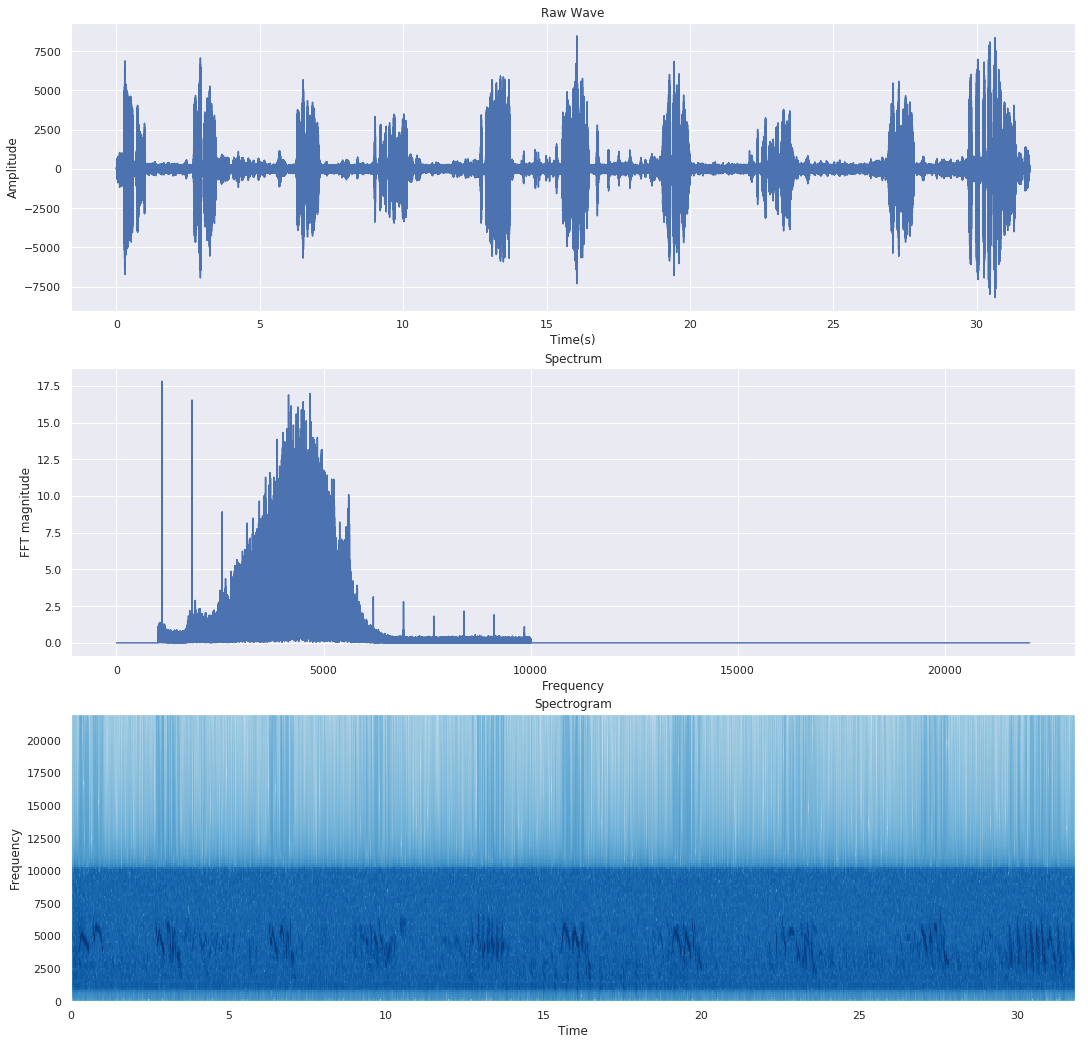

In [455]:
rate,test=select_freq_origin(rate,test)
plot_wav(rate,test)

In [456]:
#apply the power threshold method 
def select_by_PTM(rate,data):
    '''
    get a path of a wavfile and use power threshold method to get new training records
    '''
    N=int(0.01*len(data))
    mean_energy = np.mean(nlargest(N,np.abs(data)))
    data2 = np.array([i for i in data if np.abs(i) > 0.25 * mean_energy])
    
    return rate, data2

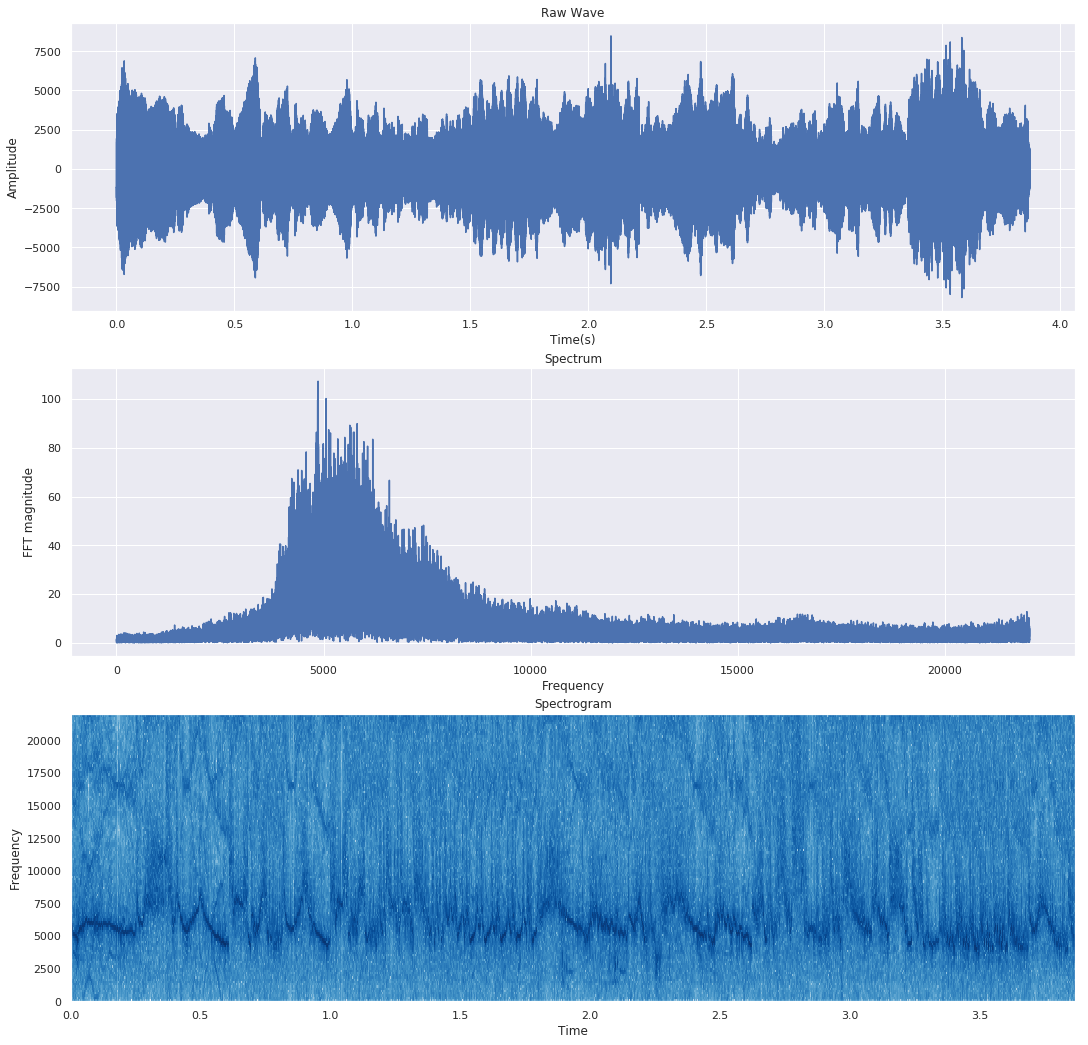

In [457]:
rate,test=select_by_PTM(rate,test)
plot_wav(rate,test)

## 1.3 Tokenization for training set

In [460]:
#Create sequences of 100-frames:
def Create_Seq(Spec):
    l_seq=[]
    nb_seq=len(Spec[0,:])//100
    for i in range(nb_seq):
        l_seq.append(Spec[:,i*100:(i+1)*100])
    return l_seq

In [463]:
#build the data set:
def data_set(name):
    #take all the samples of name_bird
    name_birds=[]
    for name2 in os.listdir('data_2/birds_wav/'):
        if '-'.join(name2.split('-')[:-1]) == name:
            name_birds.append(name2)
    data_total=[]
    for i in range(len(name_birds)):
        rate,data =wavfile.read('data_2/birds_wav/' + name_birds[i],'r')#power threshold
        if data.ndim==2:
            data=data[:,0]
        rate,data=select_by_freq(rate,data)
        print('freq',name_birds[i])
        rate,data=select_by_PTM(rate,data)
        print('PTM',name_birds[i])
        if i==0:
            data_total=data.copy()
        else:
            data_total=np.concatenate((data_total,data))
        if (i%5==0):
            print(i)
    return data_total

In [464]:
#for data set quality A
def data_setA(name):
    #take all the samples of name_bird
    name_birds=[]
    for name2 in os.listdir('data_2/A_birds_wav/'):
        if '-'.join(name2.split('-')[:-1]) == name:
            name_birds.append(name2)
    data_total=[]
    for i in range(len(name_birds)):
        rate,data =wavfile.read('data_2/birds_wav/' + name_birds[i],'r')#power threshold
        if data.ndim==2:
            data=data[:,0]
        rate,data=select_by_freq(rate,data)
        print('freq',name_birds[i])
        rate,data=select_by_PTM(rate,data)
        print('PTM',name_birds[i])
        if i==0:
            data_total=data.copy()
        else:
            data_total=np.concatenate((data_total,data))
        if (i%5==0):
            print(i)
    return data_total

In [465]:
#take all the birds_name
birds_name = set()

for file in os.listdir('data_2/ALL_BIRDS/'):
    birds_name.add('-'.join(file.split('-')[:-1]))
birds_name=list(birds_name) 
print(birds_name)

['Pinkfinch', 'Queenscoat', 'Lesser-Birchbeere', 'Broad-winged-Jojo', 'Bent-Beak-Riffraff', 'Orange-Pine-Plover', 'Darkwing-Sparrow', 'Qax', 'Eastern-Corn-Skeet', 'Bombadil', 'Purple-Tooting-Tout', 'Ordinary-Snape', 'Canadian-Cootamum', 'Rose-Crested-Blue-Pipit', 'Scrawny-Jay', 'Vermillion-Trillian', 'Blue-collared-Zipper', 'Green-Tipped-Scarlet-Pipit', 'Carries-Champagne-Pipit']


In [467]:
A_birds = pd.read_csv("all_birds_A.csv",encoding='latin-1')

In [468]:
A_birds.shape

(665, 9)

In [469]:
A_fileID = []
for i in range(len(A_birds)):
    bird = A_birds.iloc[i]
    A_fileID.append(bird[1])

In [224]:
for file in os.listdir('/Users/shangyuanzhang/Documents/student/X/visualisation/workplace/data_2/birds_wav/'):
    #print(file)
    if int(re.findall(r'\d+', file)[0]) in A_fileID:
        shutil.copy('/Users/shangyuanzhang/Documents/student/X/visualisation/workplace/data_2/birds_wav/' + file, \
                   '/Users/shangyuanzhang/Documents/student/X/visualisation/workplace/data_2/A_birds_wav/')

In [15]:
#get datasetA
datasetA=[]
for name in birds_name:
    data=data_setA(name)
    file1 = open(name + '.pckl', 'wb')
    pickle.dump(data, file1)
    file1.close()
    datasetA.append(data)

## 1.4 Get features vector

### 1.4.1 Get time-summarization features vector

In [472]:
#calculte fmode for a sequence:
def fmode(freq,Spec_seq):
    fm=[]
    for i in range(len(Spec_seq[0,:])):
        fm=fm + freq[np.where(Spec_seq[:,i]==max(Spec_seq[:,i]))].tolist()
    return fm

In [473]:
#calculate delta_fmode
def d_fmode(f_mode):
    fm=[]
    for i in range(len(f_mode) - 1):
        fm.append(f_mode[i + 1] - f_mode[i])
    return fm

In [474]:
# choose 5th 50th 95th percentiles of fmode and 50th 75th 95th of delta_fmode 
def features_chosen(freq,Spec_seq):
    f_mode=fmode(freq,Spec_seq)
    delta_fmode=d_fmode(f_mode)
    f_mode.sort()
    delta_fmode.sort()
    features=[f_mode[4],f_mode[49],f_mode[94],delta_fmode[49],delta_fmode[74],delta_fmode[94]]
    return features

In [589]:
#save the features and labels to a csv file
with open('A_features_dataset.csv', "w") as output:
    writer = csv.writer(output, quoting=csv.QUOTE_ALL)
    for i,data in enumerate(datasetA):
        f,t,Spec=signal.spectrogram(data,rate,window=('tukey', 0.25), nperseg=512)
        t,f,Spec=select_freq(t,f,Spec)
        l=Create_Seq(Spec)
        for seq in l:
            fe=features_chosen(f,seq)
            fe.append(birds_name[i])
            writer.writerow(fe)


### 1.4.2 Get bin histogram features

In [778]:
def fmean(f,Spec):
    f_mean=[]
    for i in range(len(Spec[0,:])):
        f_mean.append(np.sum(Spec[:,i]*f)/np.sum(Spec[:,i]))
    return f_mean    

def fstd(f,Spec,f_mean):
    f_std=[]
    for i in range(len(Spec[0,:])):
        f_std.append((np.sum(Spec[:,i]*((f-f_mean[i])**2))/np.sum(Spec[:,i]))**0.5)
    return f_std

In [795]:
def feature_chosen_knn(f,Seq):
    f_mean=fmean(f,Seq)
    f_std=fstd(f,Seq,f_mean)
    f_mode=fmode(f,Seq)
    f_delta_mode=d_fmode(f_mode)
    f_delta_mode.append(0)
    f_mean_edges =np.arange(1000, 10000, 89.5)
    f_std_edges = np.arange(0, 4000, 78.9)
    f_mode_edges = np.arange(1000, 10000, 89.5)
    f_delta_mode_edges = np.arange(-2000, 2000, 78.9)
    H, xedges, yedges = np.histogram2d(f_mean, f_std,(f_mean_edges,f_std_edges))
    features=H.flatten()
    h_1,f_mode_edges=np.histogram(f_mode,f_mode_edges)
    features=np.concatenate((features,h_1))##
    H, xedges, yedges = np.histogram2d(f_mode, f_delta_mode,(f_mode_edges,f_delta_mode_edges))
    features=np.concatenate((features,H),axis=None)##
    return features

dataset=[]

for name in birds_name:
    with open('useless2/'+name+'.pckl', 'rb') as f:
        dataset.append(pickle.load(f))

#trainig set
with open('A_features_dataset_knn.csv', "w") as output:
    writer = csv.writer(output, quoting=csv.QUOTE_ALL)
    fe_2=[]
    for i,data in enumerate(dataset):
        f,t,Spec=signal.spectrogram(data,rate,window=('tukey', 0.25), nperseg=512)
        t,f,Spec=select_freq_spectrogram(t,f,Spec)
        l=Create_Seq(Spec)
        for seq in l:
            fe=feature_chosen_knn(f,seq)
            fe=np.concatenate((fe,birds_name[i]),axis=None)
            writer.writerow(fe)

# 2 Classifier and performance evaluation

## 2.1 Training set and test set for SVM and KNN

In [845]:
df = pd.read_csv("A_features_dataset.csv", \
                 names=['f_mod5', 'f_mod50', 'f_mod95', 'df_mod50', 'df_mod75', 'df_mod90', 'b_name'])

In [846]:
df.describe()

f_mod5      f_mod50      f_mod95     df_mod50     df_mod75  \
count  2474.000000  2474.000000  2474.000000  2474.000000  2474.000000   
mean   3679.618817  4928.057185  6880.180439   -28.200315   476.411239   
std    1077.821701  1385.531387  1666.303390    72.679482   257.112962   
min    1205.859375  1722.656250  2239.453125  -430.664062     0.000000   
25%    2928.515625  3875.976562  5684.765625   -86.132812   258.398438   
50%    3531.445312  4909.570312  6976.757812     0.000000   430.664062   
75%    4392.773438  5598.632812  8010.351562     0.000000   602.929688   
max    8354.882812  9819.140625  9991.406250   344.531250  1894.921875   

          df_mod90  
count  2474.000000  
mean   1914.731726  
std     878.276717  
min     258.398438  
25%    1291.992188  
50%    1808.789062  
75%    2325.585938  
max    7579.687500

In [847]:
num_training = df.groupby('b_name').size()

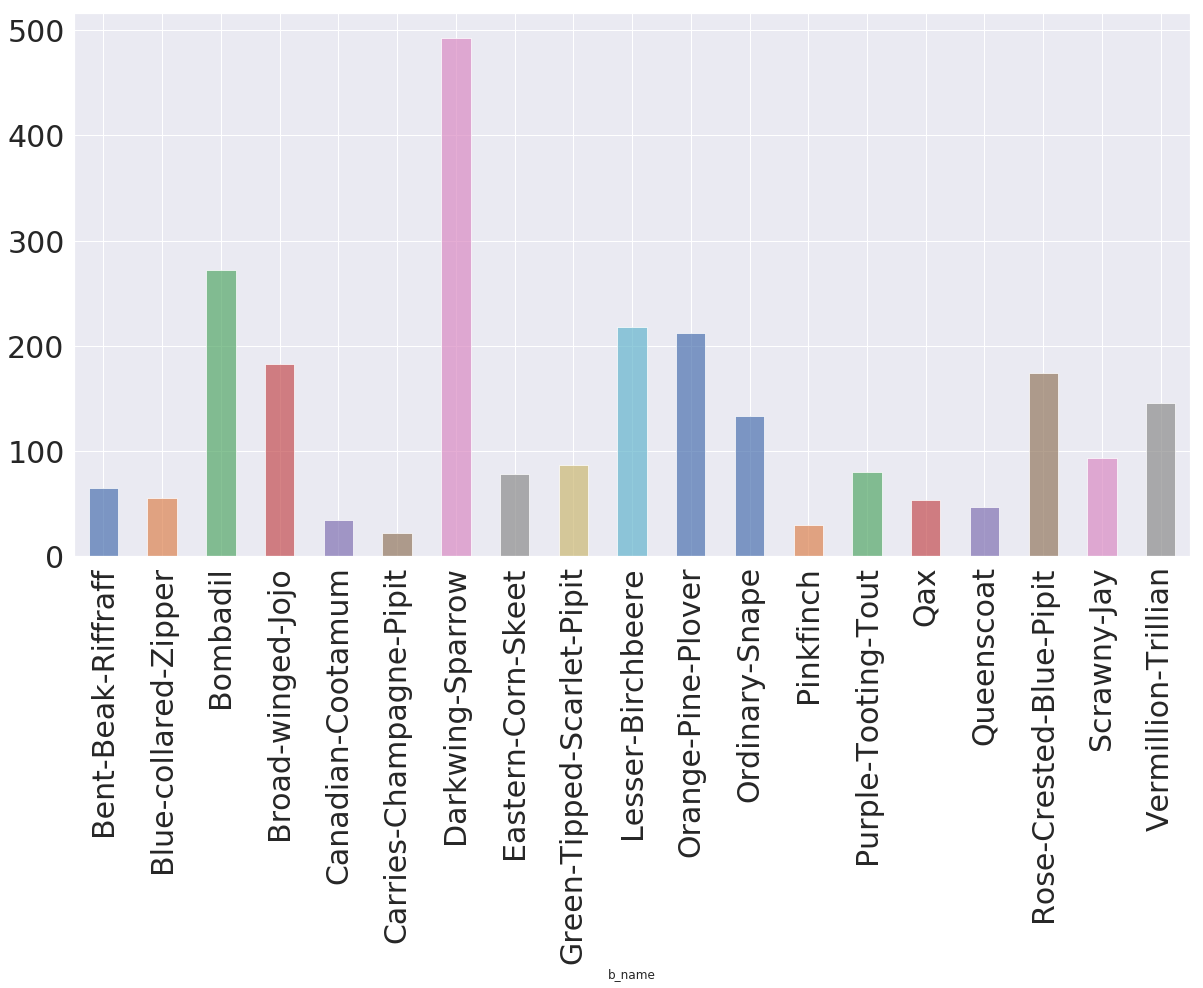

In [848]:
# show data set number for each kind of birds
num_training.plot(kind = 'bar',alpha = 0.7,figsize=(20,10), fontsize=30)

In [1099]:
# nomal training set for SVM and KNN
X = df.iloc[:,:6]
y = df.iloc[:,[6]]

In [1100]:
# for binary classfication
X_b = X.copy()
y_b = y.copy()

In [851]:
y_b['b_name'] = np.where(y_b['b_name']== 'Rose-Crested-Blue-Pipit', 1, 0)

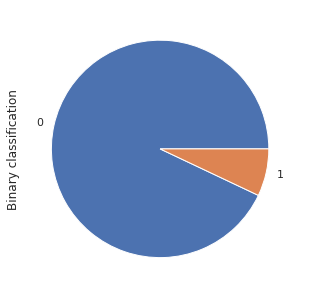

In [862]:
y_b.groupby('b_name').size().plot(kind='pie', label='Binary classification',figsize=(5,5))

In [1101]:
# sklearn y format
y = np.array(y).ravel()
y_b = np.array(y_b).ravel()

In [606]:
# test set
test_set = pd.read_csv("test_dataset_2.csv",\
                               names=['f_mod5', 'f_mod50', 'f_mod95', 'df_mod50', 'df_mod75', 'df_mod90', 'cat1'])
test_set = test_set.iloc[:,:6]

For knn classifier

In [1011]:
df_knn = pd.read_csv('A_features_dataset_knn.csv',header=None)
df_knn.shape

(2474, 10101)

In [1069]:
X_knn = df_knn.iloc[:,:10100]
y_knn = df_knn.iloc[:,[10100]]
y_knn = np.array(y_knn).ravel()

# mean std
X_knn_f1 = df_knn.iloc[:,:5000]
# mod
X_knn_f2 = df_knn.iloc[:,5000:5100]
# mod dmod
X_knn_f3 = df_knn.iloc[:,5100:10100]


In [1034]:
test_knn = pd.read_csv('Test_features_dataset_knn.csv', header=None)
test_knn_f1 = test_knn.iloc[:,:5000]
test_knn_f2 = test_knn.iloc[:,5000:5100]
test_knn_f3 = test_knn.iloc[:,5100:10100]

## 2.2 SVM 

In [768]:
def data_for_svm(x,y):
    '''
    retrun proper training foramt for svm
    '''
    x = preprocessing.scale(x)
    y = np.array(y).ravel() 
    
    return x,y

def data_for_svm_b(x,y):
    x = preprocessing.scale(x)
    y1 = np.array(y).ravel()
    y2 = y1 == 'Rose-Crested-Blue-Pipit'
    y3 = y2.astype(int)
    return x,y3

def show_performance(x,y,clf,binary = False):
    '''show performamce of a classifier by a given x,y'''
    if binary:
        x, y = data_for_svm_b(x,y)
    else:
        x, y = data_for_svm(x,y)
    
    y_pred = clf.predict(x)
    print(confusion_matrix(y_test3, y_pred), "\n\n")  
    print(classification_report(y_test3, y_pred)) 

def svc_param_selection_r1(X,y,nfolds, binary=False):
    Cs = [ 0.25,0.5, 0.75, 1, 2]
    gammas = [0.001, 0.01, 0.1, 1, 2, 3,'scale']
    class_weights = ['balanced', None]
    shrinkings = [True, False]
    decision_function_shapes = ['ovo', 'ovr']
    param_grid = {'C': Cs, 'gamma' : gammas, 'class_weight' : class_weights, \
                 'shrinking': shrinkings, 'decision_function_shape' : decision_function_shapes}
    if binary:
        grid_search = GridSearchCV(svm.SVC(kernel='rbf',verbose=True),param_grid, \
                               cv=nfolds, scoring='f1')
    else:
        grid_search = GridSearchCV(svm.SVC(kernel='rbf',verbose=True),param_grid, \
                               cv=nfolds, scoring='f1_macro') #f1 score for unbalanced training set
    grid_search.fit(X,y)
    grid_search.best_params_
    return grid_search.best_params_

def svc_param_selection_r2(X,y,nfolds):
    Cs = list(np.linspace(1.5,3,16))
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',\
                                       shrinking=True, verbose=True,decision_function_shape='ovo'),\
                               param_grid,cv=nfolds, scoring='f1_macro') #f1 score for unbalanced training set
    grid_search.fit(X,y)
    grid_search.best_params_
    return grid_search.best_params_

def svc_param_selection_r3(X,y,nfolds):
    Cs = list(np.linspace(1.5,3,16))
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf',gamma=1,class_weight='balanced',\
                                       shrinking=True, verbose=True,decision_function_shape='ovo'),\
                               param_grid,cv=nfolds, scoring='f1') #f1 score for unbalanced training set
    grid_search.fit(X,y)
    grid_search.best_params_
    return grid_search.best_params_

def svc_param_selection(X,y,nfolds):
    Cs = [ 0.1,0.25,0.5, 0.75, 1, 2,5,10]
    gammas = [0.001, 0.01, 0.1, 1, 2, 10,100,'scale']
    class_weights = ['balanced', None]
    shrinkings = [True, False]
    decision_function_shapes = ['ovo', 'ovr']
    param_grid = {'C': Cs, 'gamma' : gammas, 'class_weight' : class_weights, \
                 'shrinking': shrinkings, 'decision_function_shape' : decision_function_shapes}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf',verbose=True),param_grid, \
                               cv=nfolds, scoring='f1_macro') #f1 score for unbalanced training set
    grid_search.fit(X,y)
    grid_search.best_params_
    return grid_search.best_params_

### 2.2.1 Multi-class classification

In [750]:
X_svm = preprocessing.scale(X)
y_svm = y
test_svm = preprocessing.scale(test_set)


In [16]:
best_para_svm1 = svc_param_selection_r1(X_svm, y_svm, 7)

In [582]:
best_para_svm1

{'C': 2,
 'class_weight': 'balanced',
 'decision_function_shape': 'ovo',
 'gamma': 'scale',
 'shrinking': True}

In [17]:
best_para_svm2 = svc_param_selection_r2(X_svm, y_svm, 7)

In [628]:
best_para_svm2

{'C': 1.8}

In [930]:
svm_1 = svm.SVC(C=1.8,class_weight='balanced',decision_function_shape='ovo',\
                verbose=True,gamma='scale',shrinking=True,cache_size=2000,probability=True)
svm_1.fit(X_svm, y_svm)

[LibSVM]

SVC(C=1.8, cache_size=2000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [931]:
cross_val_score(svm_1, X_svm, y_svm, cv = 10)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

array([0.47859922, 0.47081712, 0.43873518, 0.43373494, 0.5465587 ,
       0.49795918, 0.5942623 , 0.61570248, 0.55833333, 0.47916667])

In [1090]:
f1_score(y_svm,svm_1.predict(X_svm),average='macro')

0.565833421979476

In [1091]:
svm_1.score(X_svm, y_svm)

0.6139854486661277

In [933]:
proba_svm = svm_1.predict_proba(test_svm)

Text(16.5, -1, 'Target line')

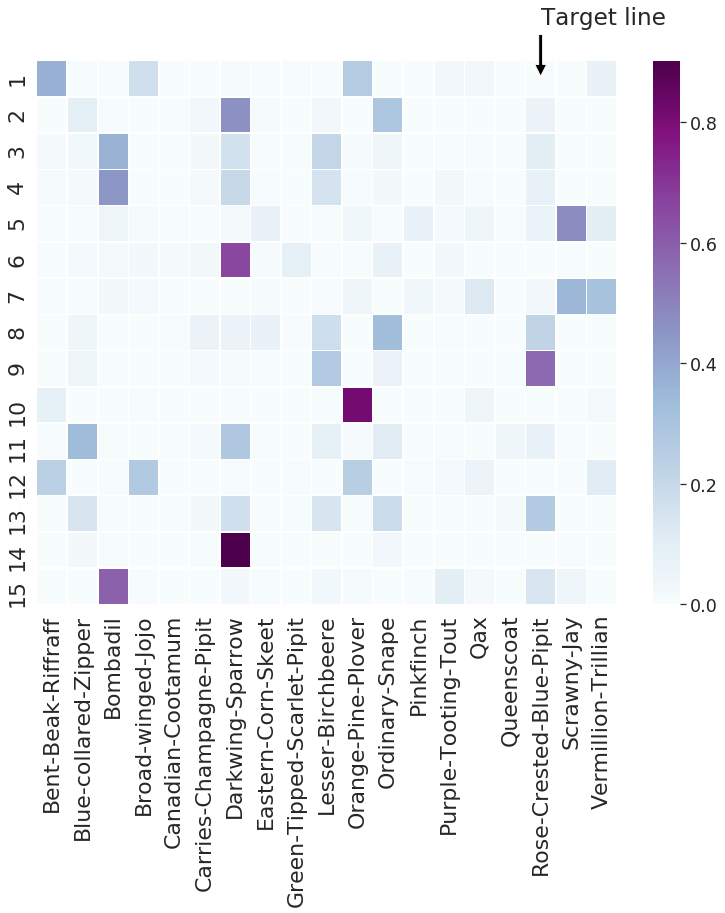

In [944]:
fig, ax = plt.subplots(figsize=(13,10))
sns.set(font_scale=1.6)
sns.heatmap(proba_svm,linewidths=0.5,cmap='BuPu',xticklabels=birds_name,yticklabels=np.arange(1,16))
ax.annotate('Target line', xy=(16.5, 0.5), xytext=(16.5, -1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize='large'
            )

<div class="alert alert-success">
We can find that sample 9 and 13 are classified to Rose-Crested-Blue-Pipit
</div>

### 2.2.2 binary classification

In [756]:
X_svm_b = preprocessing.scale(X)
y_svm_b = y_b
test_svm_b = preprocessing.scale(test_set)

In [18]:
best_para_svm_b1 = svc_param_selection_r1(X_svm_b, y_svm_b,7, binary=True)

In [761]:
best_para_svm_b1

{'C': 2,
 'class_weight': 'balanced',
 'decision_function_shape': 'ovo',
 'gamma': 1,
 'shrinking': True}

In [19]:
best_para_svm_b1 = svc_param_selection_r3(X_svm_b, y_svm_b,7)

In [771]:
best_para_svm_b1

{'C': 2.6}

In [772]:
svm_b1 = svm.SVC(C=2.6,class_weight='balanced',decision_function_shape='ovo',\
                verbose=True,gamma=1,shrinking=True,cache_size=2000,probability=True)
svm_b1.fit(X_svm_b, y_svm_b)

[LibSVM]

SVC(C=2.6, cache_size=2000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [773]:
cross_val_score(svm_b1, X_svm_b, y_svm_b, cv = 10)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

array([0.78225806, 0.89112903, 0.93548387, 0.91935484, 0.98785425,
       0.91093117, 0.93927126, 0.83805668, 0.89473684, 0.87854251])

In [775]:
proba_svm_b = svm_b1.predict_proba(test_svm_b)

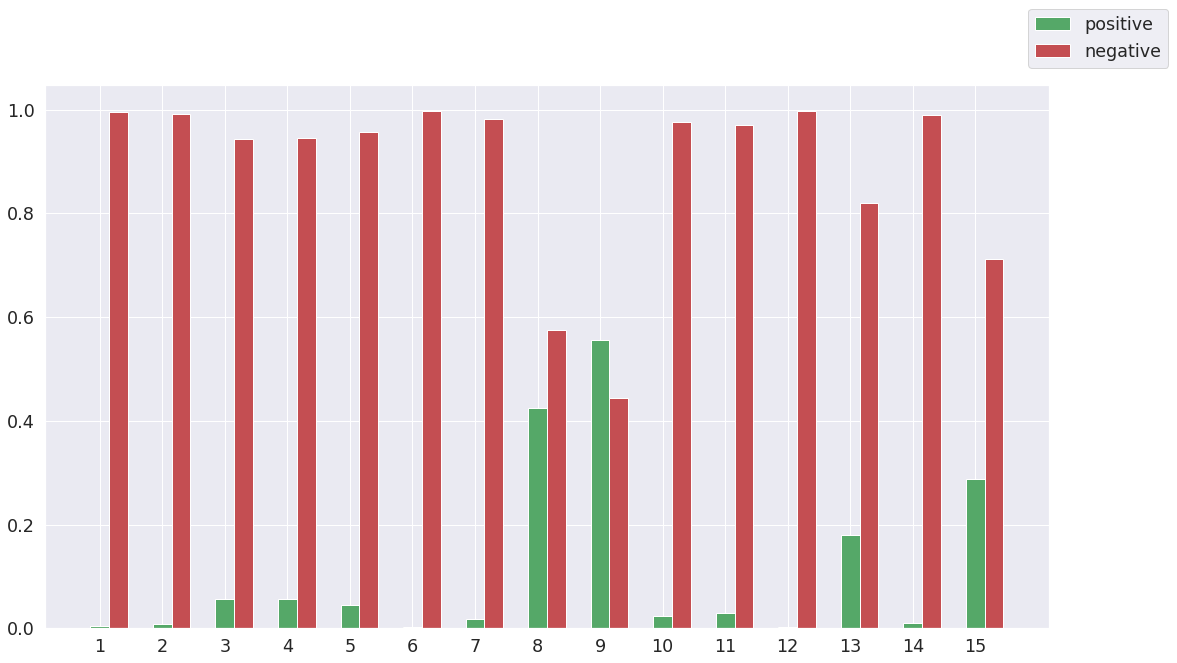

In [1009]:
fig, ax = plt.subplots(figsize=(18,10))
ax.bar(range(1,16),proba_svm_b[:,1],width=0.3,label='positive',fc='g')
ax.bar(np.linspace(1.3,15.3,15),proba_svm_b[:,0],width=0.3,label='negative',fc='r')
ax.set_xticks(np.arange(1, 16, 1.0))
fig.legend()

<div class="alert alert-success">
We can find that sample 9 is classified to Rose-Crested-Blue-Pipit.
</div>

## 2.3 KNN

In [1021]:
def mydist(H_1,H_2):
    return(sp.stats.entropy(H_1+0.01,H_2+0.01))

def knn_param_selection(X,y,nfolds):
    n_neighborss = list(range(1,10))
    param_grid = {'n_neighbors': n_neighborss}
    grid_search = GridSearchCV(KNeighborsClassifier(algorithm='ball_tree',metric=mydist,p=1),param_grid,cv=nfolds,scoring='f1_macro')
    grid_search.fit(X,y)
    grid_search.best_params_
    return grid_search.best_params_

#nbrs=KNeighborsClassifier(n_neighbors=8, algorithm='ball_tree',metric=mydist,p=1)

### 2.3.1 Feature1 (f_mean, f_std)

In [1053]:
X_knn1 = X_knn_f1.copy()
y_knn1 = y_knn.copy()
test_knn1 = test_knn_f1.copy()

In [1050]:
knn1 =  KNeighborsClassifier(n_neighbors=17,algorithm='ball_tree',metric=mydist,p=1)
knn1.fit(X_knn1,y_knn1)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
           metric=<function mydist at 0x1e16205730>, metric_params=None,
           n_jobs=None, n_neighbors=17, p=1, weights='uniform')

In [1051]:
knn1.predict(test_knn1)

array(['Orange-Pine-Plover', 'Ordinary-Snape',
       'Green-Tipped-Scarlet-Pipit', 'Darkwing-Sparrow', 'Scrawny-Jay',
       'Green-Tipped-Scarlet-Pipit', 'Scrawny-Jay', 'Lesser-Birchbeere',
       'Rose-Crested-Blue-Pipit', 'Orange-Pine-Plover', 'Ordinary-Snape',
       'Orange-Pine-Plover', 'Rose-Crested-Blue-Pipit',
       'Darkwing-Sparrow', 'Vermillion-Trillian'], dtype=object)

In [1085]:
knn1.score(X_knn1, y_knn1)

0.6119644300727567

In [1084]:
f1_score(y_knn1,knn1.predict(X_knn1),average='macro')

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5160154419151373

Text(16.5, -1, 'Target line')

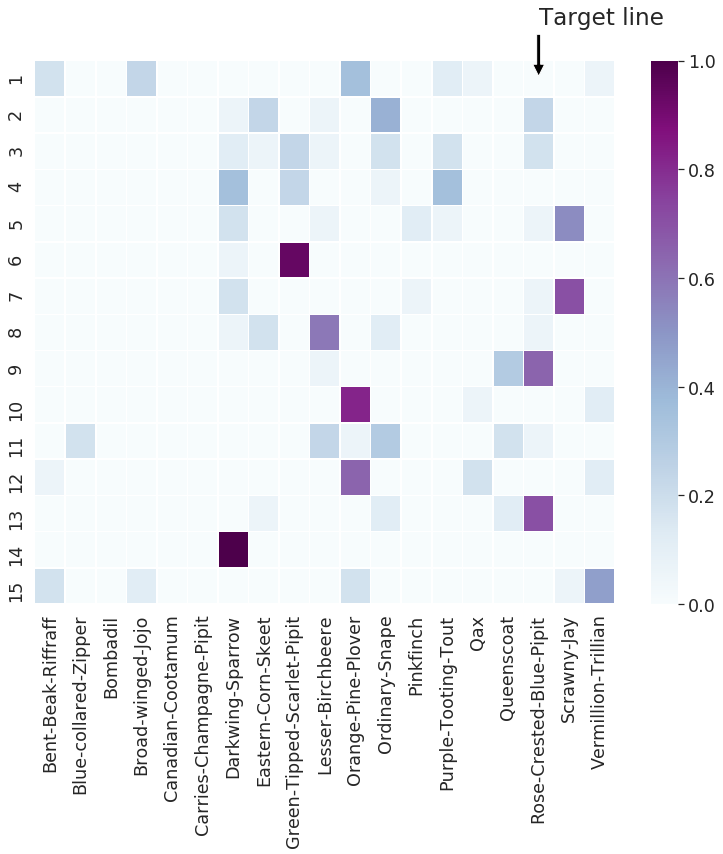

In [1052]:
proba_knn1 = knn1.predict_proba(test_knn1)
fig, ax = plt.subplots(figsize=(13,10))
sns.set(font_scale=1.6)
sns.heatmap(proba_knn1,linewidths=0.5,cmap='BuPu',xticklabels=birds_name,yticklabels=np.arange(1,16))
ax.annotate('Target line', xy=(16.5, 0.5), xytext=(16.5, -1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize='large'
            )

<div class="alert alert-success">
We can find that sample 9 and 13 are classified to Rose-Crested-Blue-Pipit.
</div>

### 2.3.2 Feature2 (f_mode)

In [1070]:
X_knn2 = X_knn_f2.copy()
y_knn2 = y_knn.copy()
test_knn2 = test_knn_f2.copy()

In [1071]:
knn2 =  KNeighborsClassifier(n_neighbors=17,algorithm='ball_tree',metric=mydist,p=1)
knn2.fit(X_knn2,y_knn2)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
           metric=<function mydist at 0x1e16205730>, metric_params=None,
           n_jobs=None, n_neighbors=17, p=1, weights='uniform')

In [1072]:
knn2.predict(test_knn2)

array(['Broad-winged-Jojo', 'Ordinary-Snape', 'Bombadil', 'Bombadil',
       'Scrawny-Jay', 'Darkwing-Sparrow', 'Eastern-Corn-Skeet',
       'Ordinary-Snape', 'Rose-Crested-Blue-Pipit', 'Orange-Pine-Plover',
       'Queenscoat', 'Vermillion-Trillian', 'Rose-Crested-Blue-Pipit',
       'Darkwing-Sparrow', 'Bombadil'], dtype=object)

In [1086]:
knn2.score(X_knn2,y_knn2)

0.5359741309620049

In [1083]:
f1_score(y_knn2,knn2.predict(X_knn2),average='macro')

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.3765052631923798

Text(16.5, -1, 'Target line')

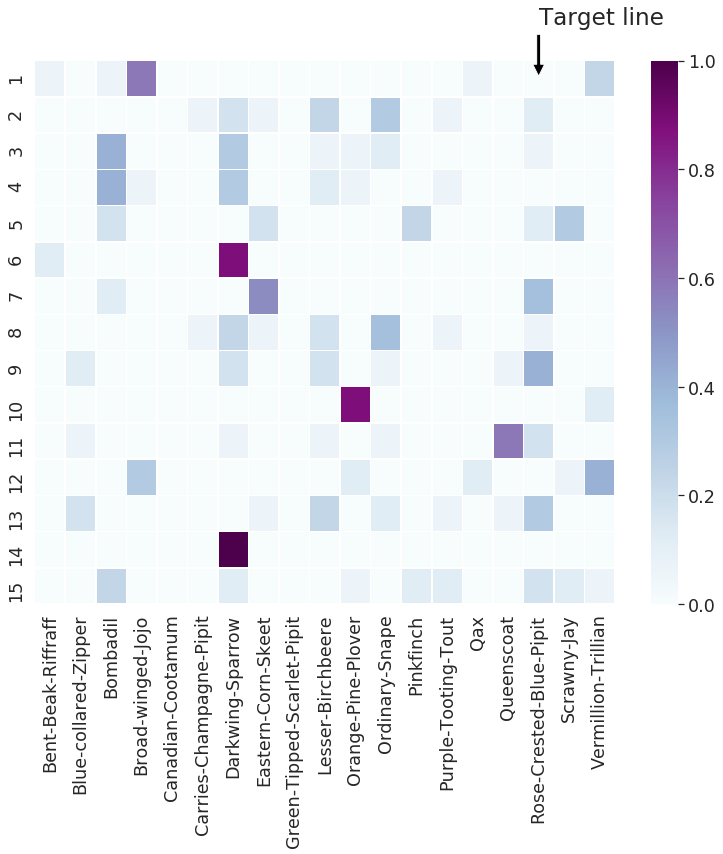

In [1073]:
proba_knn2 = knn2.predict_proba(test_knn2)
fig, ax = plt.subplots(figsize=(13,10))
sns.set(font_scale=1.6)
sns.heatmap(proba_knn2,linewidths=0.5,cmap='BuPu',xticklabels=birds_name,yticklabels=np.arange(1,16))
ax.annotate('Target line', xy=(16.5, 0.5), xytext=(16.5, -1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize='large'
            )

<div class="alert alert-success">
We can find that sample 9 and 13 are classified to Rose-Crested-Blue-Pipit.
</div>

### 2.3.3 Feature3 (f_mod, f_dmode)

In [1074]:
X_knn3 = X_knn_f3.copy()
y_knn3 = y_knn.copy()
test_knn3 = test_knn_f3.copy()

In [1075]:
knn3 =  KNeighborsClassifier(n_neighbors=17,algorithm='ball_tree',metric=mydist,p=1)
knn3.fit(X_knn3,y_knn3)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
           metric=<function mydist at 0x1e16205730>, metric_params=None,
           n_jobs=None, n_neighbors=17, p=1, weights='uniform')

In [1076]:
knn3.predict(test_knn3)

array(['Orange-Pine-Plover', 'Lesser-Birchbeere', 'Lesser-Birchbeere',
       'Lesser-Birchbeere', 'Scrawny-Jay', 'Green-Tipped-Scarlet-Pipit',
       'Eastern-Corn-Skeet', 'Lesser-Birchbeere', 'Lesser-Birchbeere',
       'Orange-Pine-Plover', 'Queenscoat', 'Orange-Pine-Plover',
       'Lesser-Birchbeere', 'Ordinary-Snape', 'Orange-Pine-Plover'],
      dtype=object)

In [1087]:
knn3.score(X_knn3,y_knn3)

0.43694421988682297

In [1082]:
f1_score(y_knn3,knn3.predict(X_knn3),average='macro')

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.3114293352285889

Text(16.5, -1, 'Target line')

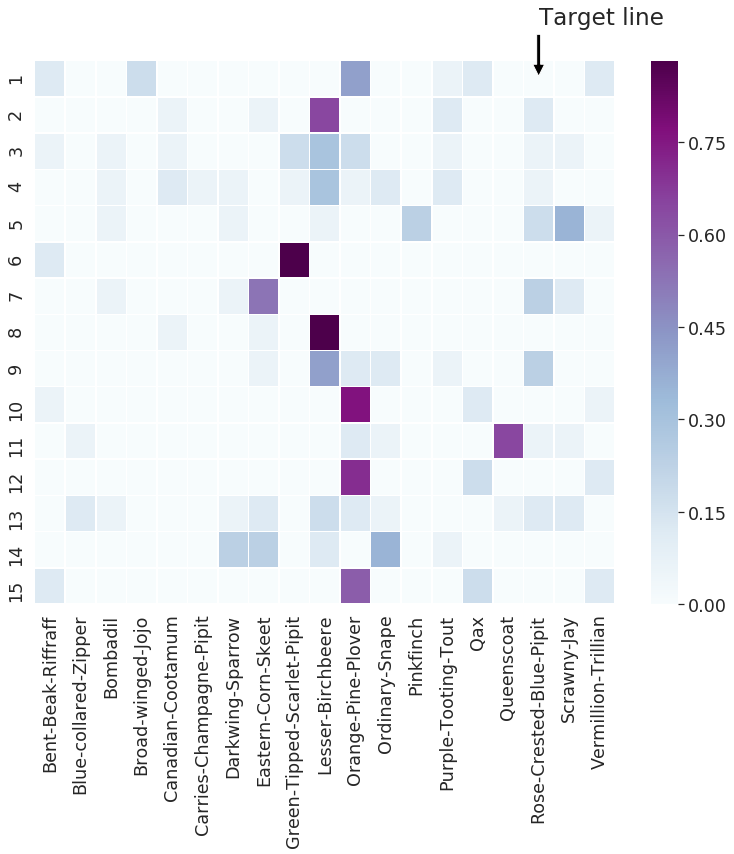

In [1078]:
proba_knn3 = knn3.predict_proba(test_knn3)
fig, ax = plt.subplots(figsize=(13,10))
sns.set(font_scale=1.6)
sns.heatmap(proba_knn3,linewidths=0.5,cmap='BuPu',xticklabels=birds_name,yticklabels=np.arange(1,16))
ax.annotate('Target line', xy=(16.5, 0.5), xytext=(16.5, -1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize='large'
            )

<div class="alert alert-success">
We can find that no one is classified to Rose-Crested-Blue-Pipit.
</div>

### 2.3.4 Feature4 (time summarization feature)

In [1102]:
X_knn4 = X.copy()
y_knn4 = y.copy()
test_knn4 = test_set.copy()

In [20]:
knn_nei1 = knn_param_selection(X_knn, y_knn, 10)

In [682]:
knn_nei1

{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

In [1103]:
knn4 =  KNeighborsClassifier(n_neighbors=5,p=1)
knn4.fit(X_knn4,y_knn4)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=1,
           weights='uniform')

In [1104]:
pred_knn1 = knn4.predict(test_knn4)

In [1105]:
pred_knn1 #9，13 with n_neighbor = 22 (nfold = 10)

array(['Bent-Beak-Riffraff', 'Lesser-Birchbeere', 'Bombadil', 'Bombadil',
       'Pinkfinch', 'Green-Tipped-Scarlet-Pipit', 'Eastern-Corn-Skeet',
       'Lesser-Birchbeere', 'Rose-Crested-Blue-Pipit',
       'Orange-Pine-Plover', 'Ordinary-Snape', 'Vermillion-Trillian',
       'Rose-Crested-Blue-Pipit', 'Darkwing-Sparrow', 'Bombadil'],
      dtype=object)

In [1106]:
knn4.score(X_knn4,y_knn4)

0.6968472109943411

In [1107]:
f1_score(y_knn4,knn4.predict(X_knn4),average='macro')

0.6180960527460275

Text(16.5, -1, 'Target line')

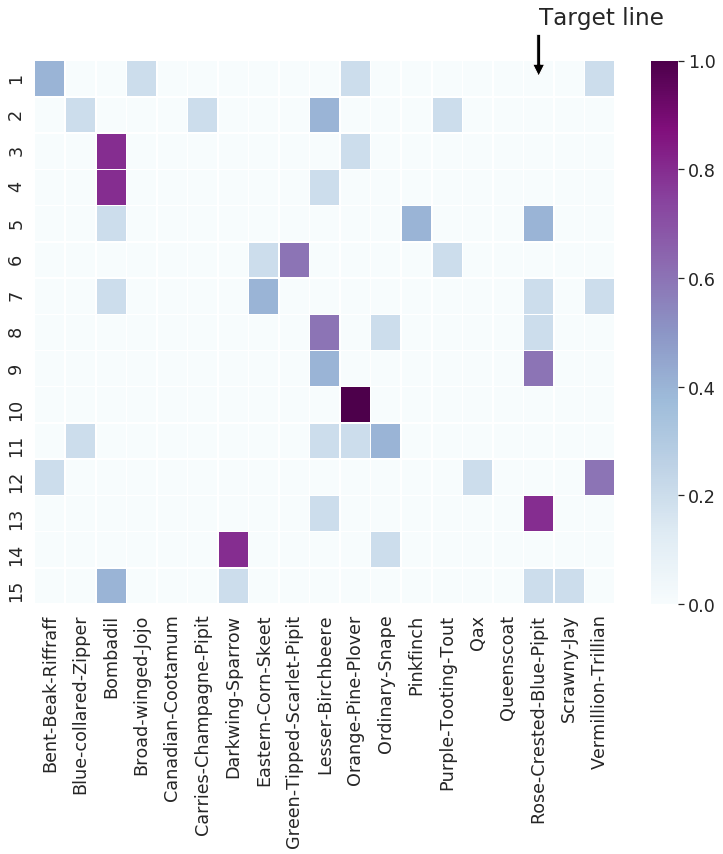

In [1109]:
proba_knn4 = knn4.predict_proba(test_knn4)
fig, ax = plt.subplots(figsize=(13,10))
sns.set(font_scale=1.6)
sns.heatmap(proba_knn4,linewidths=0.5,cmap='BuPu',xticklabels=birds_name,yticklabels=np.arange(1,16))
ax.annotate('Target line', xy=(16.5, 0.5), xytext=(16.5, -1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize='large'
            )

<div class="alert alert-success">
We can find that sample 9 and 13 are classified to Rose-Crested-Blue-Pipit.
</div>

## 2.4 Performance and result

Text(0.5, 1.0, 'Prediction with performance for each classifier')

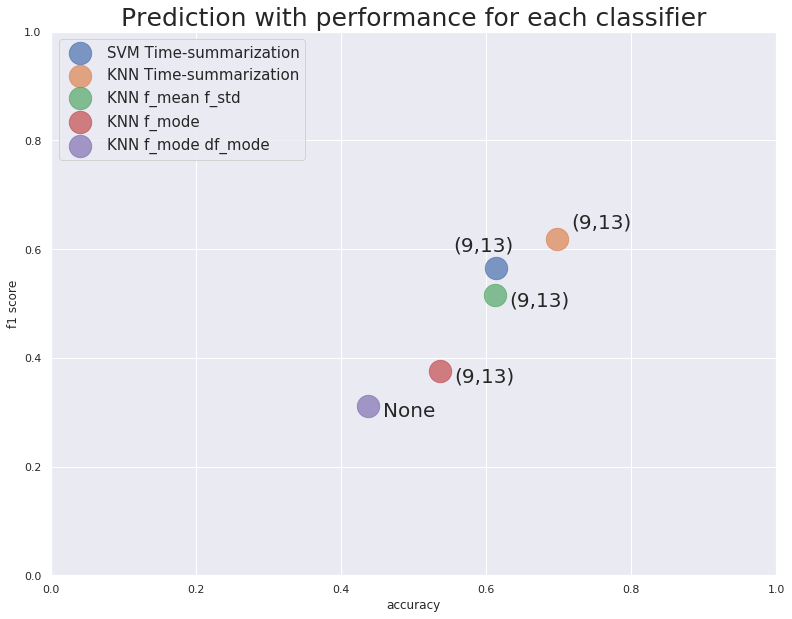

In [1169]:
svm1_per = [0.6139854486661277,0.565833421979476]
knn_f1_per = [0.6119644300727567, 0.5160154419151373]
knn_f2_per = [0.5359741309620049,0.3765052631923798]
knn_f3_per = [0.43694421988682297,0.3114293352285889]
svm2_per = [0.6968472109943411,0.6180960527460275]

fig, ax = plt.subplots(figsize=(13,10))
sns.set(font_scale=1)
ax.scatter(svm1_per[0],svm1_per[1],s=500,label='SVM Time-summarization',alpha = 0.7)
ax.scatter(svm2_per[0],svm2_per[1],s=500,label='KNN Time-summarization',alpha = 0.7)
ax.scatter(knn_f1_per[0],knn_f1_per[1],s=500,label='KNN f_mean f_std',alpha = 0.7)
ax.scatter(knn_f2_per[0],knn_f2_per[1],s=500,label='KNN f_mode',alpha = 0.7)
ax.scatter(knn_f3_per[0],knn_f3_per[1],s=500,label='KNN f_mode df_mode',alpha = 0.7)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('accuracy')
ax.set_ylabel('f1 score')
ax.legend(loc = 'upper left',prop={'size': 15})
ax.annotate('(9,13)', (svm2_per[0]+0.02, svm2_per[1]+0.02),fontsize=20)
ax.annotate('(9,13)', (svm1_per[0]-0.06, svm1_per[1]+0.03),fontsize=20)
ax.annotate('(9,13)', (knn_f1_per[0]+0.02, knn_f1_per[1]-0.02),fontsize=20)
ax.annotate('(9,13)', (knn_f2_per[0]+0.02, knn_f2_per[1]-0.02),fontsize=20)
ax.annotate('None', (knn_f3_per[0]+0.02, knn_f3_per[1]-0.02),fontsize=20)
ax.set_title('Prediction with performance for each classifier',fontsize=25)

# 3 Conclusion

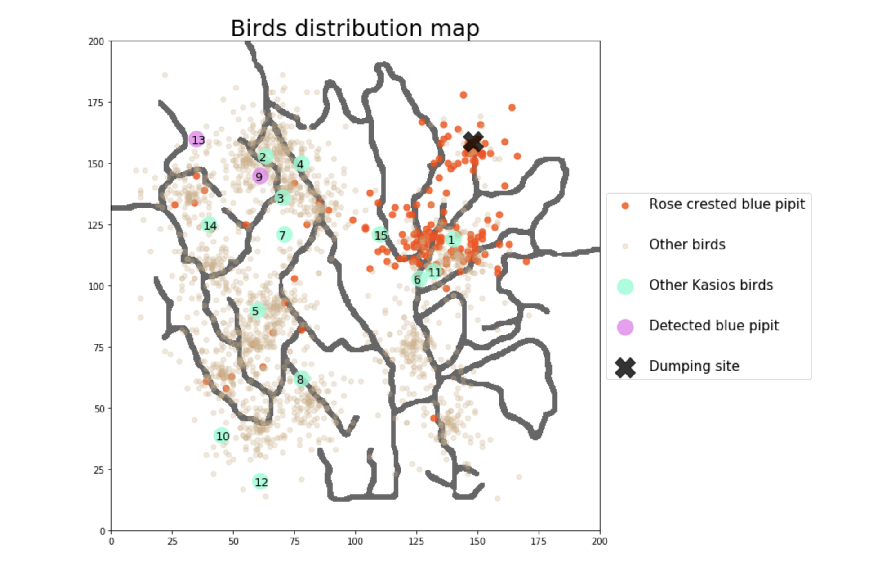

In [14]:
img=cv2.imread("final.png")
img2 = img[:,:,::-1]
plt.figure(figsize=(15,13))
plt.grid(None)
plt.axis('off')
plt.imshow(img2)

<div class="alert alert-success">
 
 1. Only sample 9 and 13 are classified to Rose-Crested-Blue-Pipit.
   
 2. The claim of Kasios is not trusty.
 
 3. The dumping site has an influence of existence of Rose-Crested-Blue-Pipit.
</div>